In [1]:
import sys
sys.path.insert(1,'/work/yifan.wang/eccentricity/src/teobresums/Python/') #import teob
sys.path.insert(1,'/work/yifan.wang/eccentricity/summer_gitlab/waveformtools/') #import my waveform tools
import EOBRun_module
import Functions as fun
import SXS_module

In [2]:
import glob

In [3]:
import argparse
from configparser import ConfigParser
import os
import json

from pycbc import psd
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft

from scipy.signal import find_peaks
import dynesty
from dynesty import plotting as dyplot
from pycbc.waveform import td_approximants
import pycbc.psd
from pycbc.pool import choose_pool
import csv
##########################

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Select the NR waveforms

In [5]:
json_files=glob.glob('/work/francisco.jimenez/RIT/Metadata/*Metadata.json',recursive = True)

In [6]:
json_files

['/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0005-n100-id0_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:eBBH:1632-n100-ecc_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:eBBH:1848-n100-ecc_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0814-n100-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0169-n140-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:eBBH:1173-n100-ecc_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0989-n100-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:eBBH:1180-n100-ecc_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:1086-n100-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:eBBH:1178-n100-ecc_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0982-n100-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:1075-n100-id1_Metadata.json',
 '/work/francisco.jimenez/RIT/Metadata/RIT:BBH:0971-n100-id1_Metadata.j

In [7]:
len(json_files)

1881

In [8]:
conditions=np.asarray([['BHBH',None],['Non-Precessing',None],['Eccentricity',['>=0.01','<=0.50']]])

/work/yifan.wang/eccentricity/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [9]:
conditions

array([['BHBH', None],
       ['Non-Precessing', None],
       ['Eccentricity', list(['>=0.01', '<=0.50'])]], dtype=object)

In [10]:
ritcat=SXS_module.SXS_catalogue("/work/francisco.jimenez/RIT/Data",conditions,catalogue="RIT")

In [11]:
systems=np.array([ritcat.metadata(j,parameters_list=
    ['catalog-tag',
    'system-type',
    'eccentricity',
    'relaxed-mass-ratio-1-over-2',
    'final-mass',
    'final-chi',
    'initial-bh-chi1z',
    'initial-bh-chi2z',
    'freq-start-22']) for j in json_files])

In [12]:
systems

array([['RIT:BBH:0005', 'Aligned', '0.0027515898', ..., '0',
        '0.666666666666667', ''],
       ['RIT:eBBH:1632', 'Precessing', '0.2775000000', ..., '0', '0',
        '0.002463369913'],
       ['RIT:eBBH:1848', 'Aligned', '0.6400000000', ..., '0', '-0.8',
        '0.002463369913'],
       ...,
       ['RIT:eBBH:1398', 'Nonspinning', '0.9999000000', ..., '0', '0',
        '0.002463369913'],
       ['RIT:eBBH:1205', 'Nonspinning', '0.0100000000', ..., '0', '0',
        '0.007390109739'],
       ['RIT:BBH:0259', 'Precessing', '0.0014294517', ..., '0',
        '0.69282032302755', '0.007935788631696']], dtype='<U20')

# TODO: change the data wrapper to pandas

In [13]:
boolean= np.array(['e' in elist for elist in systems[:,0]])#the 0th col is ecc

for i in range(len(systems)):
    if 'e' in systems[:,0][i] and float(systems[:,2][i])<0.5: #select e in [0,0.5]
        boolean[i]=True
    else:
        boolean[i]=False

In [14]:
ecc_prec_cases=systems[boolean]

In [15]:
ecc_prec_cases

array([['RIT:eBBH:1632', 'Precessing', '0.2775000000', ..., '0', '0',
        '0.002463369913'],
       ['RIT:eBBH:1173', 'Nonspinning', '0.2000000000', ..., '0', '0',
        '0.007390109739'],
       ['RIT:eBBH:1180', 'Nonspinning', '0.2350000000', ..., '0', '0',
        '0.007390109739'],
       ...,
       ['RIT:eBBH:1862', 'Aligned', '0.3600000000', ..., '0', '-0.8',
        '0.002463369913'],
       ['RIT:eBBH:1152', 'Nonspinning', '0.0950000000', ..., '0', '0',
        '0.007390109739'],
       ['RIT:eBBH:1205', 'Nonspinning', '0.0100000000', ..., '0', '0',
        '0.007390109739']], dtype='<U20')

In [16]:
len(ecc_prec_cases)

260

In [17]:
boolean = np.array(['Precessing' not in elist for elist in ecc_prec_cases])
ecc_cases=ecc_prec_cases[boolean]

In [18]:
len(ecc_cases)

252

In [19]:
ecc_cases[0]

array(['RIT:eBBH:1173', 'Nonspinning', '0.2000000000',
       '0.250001621816471', '0.9784859393', '0.4757486824', '0', '0',
       '0.007390109739'], dtype='<U20')

In [20]:
ecc_cases[:,2]=np.array([float(i[2]) for i in ecc_cases])   #ecc
ecc_cases[:,3]=np.array([1/float(i[3]) for i in ecc_cases]) #mass ratio
ecc_cases[:,4]=np.array([float(i[4]) for i in ecc_cases])   #final mass
ecc_cases[:,5]=np.array([float(i[5]) for i in ecc_cases])   #final spin
ecc_tags=ecc_cases[:,0]

In [21]:
ecc_tags

array(['RIT:eBBH:1173', 'RIT:eBBH:1180', 'RIT:eBBH:1178', 'RIT:eBBH:1843',
       'RIT:eBBH:1224', 'RIT:eBBH:1400', 'RIT:eBBH:1101', 'RIT:eBBH:1097',
       'RIT:eBBH:1256', 'RIT:eBBH:1517', 'RIT:eBBH:1333', 'RIT:eBBH:1740',
       'RIT:eBBH:1164', 'RIT:eBBH:1356', 'RIT:eBBH:1233', 'RIT:eBBH:1116',
       'RIT:eBBH:1241', 'RIT:eBBH:1201', 'RIT:eBBH:1540', 'RIT:eBBH:1425',
       'RIT:eBBH:1156', 'RIT:eBBH:1273', 'RIT:eBBH:1539', 'RIT:eBBH:1124',
       'RIT:eBBH:1378', 'RIT:eBBH:1216', 'RIT:eBBH:1765', 'RIT:eBBH:1141',
       'RIT:eBBH:1301', 'RIT:eBBH:1264', 'RIT:eBBH:1297', 'RIT:eBBH:1138',
       'RIT:eBBH:1133', 'RIT:eBBH:1808', 'RIT:eBBH:1140', 'RIT:eBBH:1883',
       'RIT:eBBH:1764', 'RIT:eBBH:1217', 'RIT:eBBH:1379', 'RIT:eBBH:1139',
       'RIT:eBBH:1296', 'RIT:eBBH:1265', 'RIT:eBBH:1902', 'RIT:eBBH:1157',
       'RIT:eBBH:1424', 'RIT:eBBH:1200', 'RIT:eBBH:1125', 'RIT:eBBH:1538',
       'RIT:eBBH:1272', 'RIT:eBBH:1232', 'RIT:eBBH:1165', 'RIT:eBBH:1741',
       'RIT:eBBH:1117', '

In [22]:
h5_files=[glob.glob('/work/francisco.jimenez/RIT/Data/*'+j.replace(':','-')+'*',recursive = True)[0] \
          for j in ecc_tags]

In [23]:
h5_files

['/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1173-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1180-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1178-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1843-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1224-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1400-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1101-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1097-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1256-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1517-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1333-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1740-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1164-n100.h5',
 '/work/francisco.jimenez/RIT/Data/ExtrapStrain_RIT-eBBH-1356-n1

In [24]:
len(ecc_tags),len(h5_files)

(252, 252)

# 252 spin-aligned eccentric BBH waveforms from RIT catalog

In [25]:
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from pycbc.pool import choose_pool
import dynesty

In [26]:
wave={}
i=123
tag=ecc_tags[i]
wave[tag]=SXS_module.Generate_Georgia_Waveform(h5_files[i],modes=[[2,2]],
                                zero_align=False,
                                sampling_rate=0.1,modes_combined=False,inclination=0,
                                coa_phase=0,RD=False,toffset=0)

In [27]:
ecc_tags[i]

'RIT:eBBH:1248'

In [28]:
wave['RIT:eBBH:1248']

[array([[-1.33833333e+03+0.00000000e+00j,  1.83204560e-23+2.68367298e-46j],
        [-1.33823333e+03+0.00000000e+00j, -8.49046849e-09+3.61456478e-16j],
        [-1.33813332e+03+0.00000000e+00j, -1.48200861e-08+1.02716483e-15j],
        ...,
        [ 5.17466656e+02+0.00000000e+00j, -7.83803934e-10+1.04193593e-18j],
        [ 5.17566662e+02+0.00000000e+00j, -3.94272074e-10+2.63649001e-19j],
        [ 5.17666667e+02+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j]])]

In [29]:
rit_t=wave[tag][0][:,0]
rit_h=wave[tag][0][:,1]

In [30]:
ecc_cases

array([['RIT:eBBH:1173', 'Nonspinning', '0.2', ..., '0', '0',
        '0.007390109739'],
       ['RIT:eBBH:1180', 'Nonspinning', '0.235', ..., '0', '0',
        '0.007390109739'],
       ['RIT:eBBH:1178', 'Nonspinning', '0.225', ..., '0', '0',
        '0.007390109739'],
       ...,
       ['RIT:eBBH:1862', 'Aligned', '0.36', ..., '0', '-0.8',
        '0.002463369913'],
       ['RIT:eBBH:1152', 'Nonspinning', '0.095', ..., '0', '0',
        '0.007390109739'],
       ['RIT:eBBH:1205', 'Nonspinning', '0.01', ..., '0', '0',
        '0.007390109739']], dtype='<U20')

Found! RIT:eBBH:1248
system type: Nonspinning
eccentricity 0.02
relaxed_mass_ratio_1_over_2: 3
final_mass: 0.9534286843
final_chi: 0.6750638875
initial_bh_chi1z: 0
initial_bh_chi2z: 0
initial_freq: 0.007390109739
times[0] -1338.333333


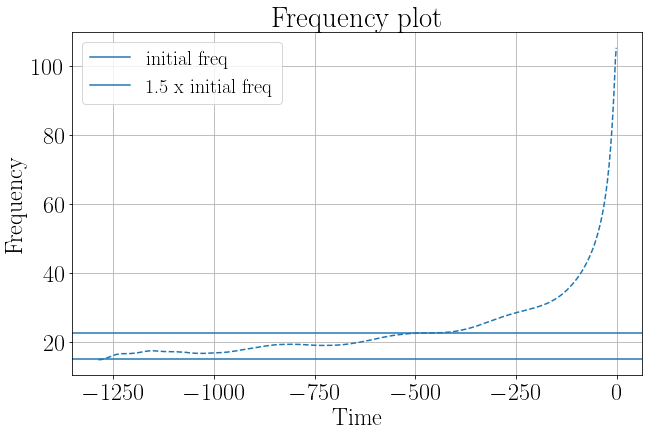

In [33]:
#----------------------------------------------------------------------
for name in ecc_cases:
    if name[0]==ecc_tags[i]:
        ritwavename=str(name[0])
        print("Found! " + str(name[0]))
        system_type=name[1]
        print("system type: " + str(system_type))
        eccentricity = name[2]
        print("eccentricity "+str(eccentricity))
        relaxed_mass_ratio_1_over_2=[3][0]
        print("relaxed_mass_ratio_1_over_2: "+ str(relaxed_mass_ratio_1_over_2))
        final_mass=name[4]
        print("final_mass: "+ str(final_mass))
        final_chi=name[5]
        print("final_chi: "+ str(final_chi))
        initial_bh_chi1z=name[6]
        print("initial_bh_chi1z: "+ str(initial_bh_chi1z))
        initial_bh_chi2z=name[7]
        print("initial_bh_chi2z: "+ str(initial_bh_chi2z))
        initial_freq=float(name[8])
        print(("initial_freq: "+ str(initial_freq)))
#----------------------------------------------------------------------
initial_freq=1*initial_freq
rit_wave_int=interp1d(rit_t.real,rit_h, kind='cubic') #cubic spline interpolation
mass=100
sxs_wave_int=rit_wave_int
times=rit_t.real
print('times[0]',times[0])

dt=fun.time_to_t_NR(1/1024.,mass) #convert 1/1024s to NR time using 100 solar mass
times= np.arange(times[0], times[-1], dt)
sxs_wave = sxs_wave_int(times)

beginning_time=times[0]
#remove junk radiation
boolean=np.logical_and(times >= (times[0]+50), times<=0)
sxs_wave = sxs_wave[boolean]
times = times[boolean]

# time frequency
sxsphas = np.angle(sxs_wave)
sxsphas = np.unwrap(sxsphas)
sxsfreq = np.gradient(sxsphas, times)
sxsfreq_int = interp1d(times,sxsfreq,kind='cubic')

#plot
plt.plot(times, fun.f_to_Phys(sxsfreq,mass)/(2*np.pi), '--')
plt.axhline(fun.f_to_Phys(initial_freq,mass),label='initial freq')
plt.axhline(fun.f_to_Phys(1.5*initial_freq,mass),label='1.5 x initial freq')
plt.legend()
plt.title("Frequency plot")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

massratio:  3
mass1:  75.0
mass2:  25.0
spin1:  0.0
spin2:  0.0
Meta eccentricity 0.02
eccentricity estimate:  0.018543568542215363
initial physical frequency:  15.006968144780863
---------------


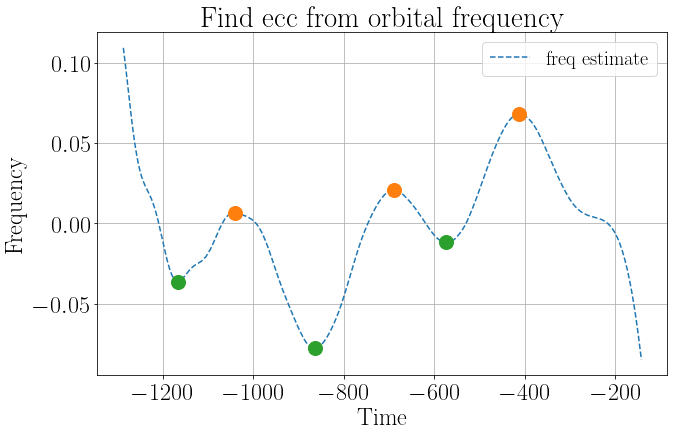

In [34]:
#---------------------------------------------------------------------
ecc_nr=eccentricity
massratio=relaxed_mass_ratio_1_over_2
mass1=100*1/(massratio+1)*massratio
mass2=100*1/(massratio+1)
spin1=float(initial_bh_chi1z)
spin2=float(initial_bh_chi2z)
omega_0=initial_freq*2*np.pi
T_0= 2*np.pi/omega_0
f_0 = initial_freq

bool_fact=times<=times[0]+100+8*T_0
times_fit=times[bool_fact]
sxsfreq_fit=sxsfreq[bool_fact]

freqcfit=np.polyfit(times_fit, sxsfreq_fit, 2)
sxsfreq_fitc = np.poly1d(freqcfit)
sxsfreq_ecc_estimate=1-sxsfreq_fit/sxsfreq_fitc(times_fit)
sxsfreq_ecc_estimate=fun.moving_average(sxsfreq_ecc_estimate, 20)

times_fit = times_fit[:-19]
peaks_pos=find_peaks(sxsfreq_ecc_estimate, height=0)
peaks_neg=find_peaks(-sxsfreq_ecc_estimate, height=-0)

plt.plot(times_fit, sxsfreq_ecc_estimate, '--', label='freq estimate')
plt.plot(times_fit[peaks_pos[0]], peaks_pos[1]['peak_heights'], 'o')
plt.plot(times_fit[peaks_neg[0]],-peaks_neg[1]['peak_heights'], 'o')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title("Find ecc from orbital frequency")

# eccentricity estimate as in Eq. 2.8 odf 1909.11011
wp =omega_0*(1 + np.mean(peaks_pos[1]['peak_heights']))
wa =omega_0*(1 - np.mean(peaks_neg[1]['peak_heights']))
if wa>=0.:
    ecc_NR = (wp**0.5 - wa**0.5)/(wp**0.5 + wa**0.5)
else:
    ecc_NR = eccentricity

initial_freq_phys=fun.f_to_Phys(initial_freq,mass)
print('massratio: ',massratio)
print('mass1: ',mass1)
print('mass2: ',mass2)
print('spin1: ',spin1)
print('spin2: ',spin2)
print('Meta eccentricity', eccentricity)
print('eccentricity estimate: ', ecc_NR)
print('initial physical frequency: ', fun.f_to_Phys(initial_freq,mass))
print('---------------')

In [35]:
import corner

In [36]:
mass1

75.0

In [37]:
#---------------------------------------------------------------------
emin=0
distance = 100; inclination = 0; l=2; m=2;
emax=0.1
if float(eccentricity)>emax:
    emax=0.41
    
bvals=[]
model='SEOBNREHM'
ecc_clas=fun.Eccentricity_PE([mass1,mass2,spin1,spin2,distance],
                             sxsfreq_int,
                             model=model,
                             times=times,
                             sxsfreq=sxsfreq,
                             emin=emin,
                             emax=emax,
                             fmin=initial_freq_phys,
                             fmax=18)#fmax=1.5*initial_freq_phys

ecc_clas.log_likelihood([0.1,10])

-0.010081849164200789

Running dynesty...


26it [01:19,  3.04s/it, +10 | bound: 0 | nc: 1 | ncall: 189 | eff(%): 20.112 | loglstar:   -inf < -0.007 <    inf | logz: -0.068 +/-    nan | dlogz:  0.008 >  0.100]


Summary
nlive: 10
niter: 26
ncall: 179
eff(%): 20.112
logz: -0.068 +/-  0.077


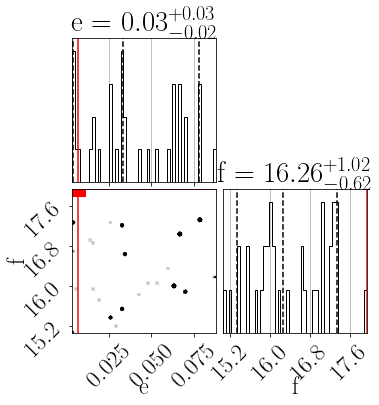

bvals: [6.87961495e-03 1.79411110e+01]


In [38]:
if bvals==[]:
    print("Running dynesty...")
    #Define min and max eccentricity for the priors
    pool = choose_pool(8)
    pool.size=8
    nlive = 10
    f2=dynesty.NestedSampler(ecc_clas.log_likelihood,
                             ecc_clas.prior_transform,
                             2,
                             nlive=nlive,
                             sample='rwalk',
                             pool=pool)
    f2.run_nested(print_progress=True,dlogz=0.1)
    pool.close()
    res = f2.results
    res.samples_u.shape
    res.summary()
    samps=f2.results.samples
    postsamps = fun.posterior_samples(f2)
    bvals = postsamps[-1]
    fg=corner.corner(postsamps,
                     quantiles=[0.05,0.5,0.95],
                     show_titles=True,
                     max_n_ticks = 4,
                     bins=50,
                     truths=bvals,
                     labels=['e','f'],
                     truth_color='red')
    plt.show()
else:
    print("Skipped dynesty...")
    bvals=bvals
print("bvals: "+ str(bvals))

In [58]:
mass

range(10, 200)

Text(0.5, 1.0, 'Data')

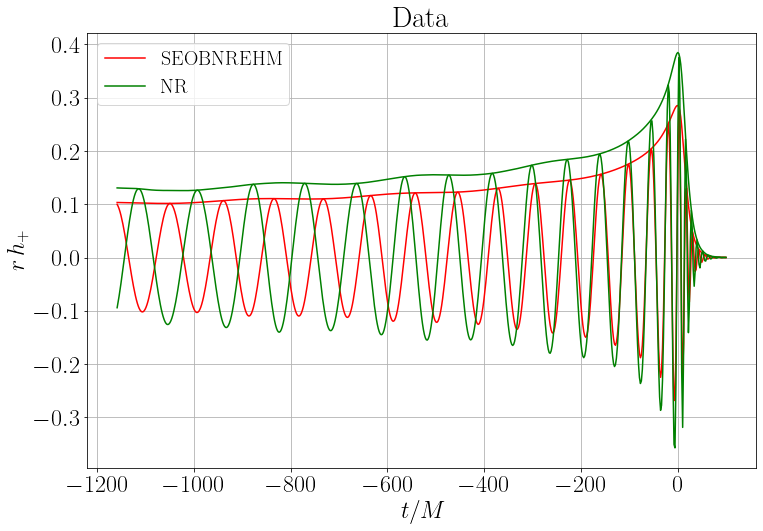

In [62]:
#----------------------------------------------------------------------
dict = {'SEOBNREHM':ecc_clas.model_SEOBNREHM,
        'SEOBNRE':ecc_clas.model_SEOBNRE,
        'TSEOBNRE':ecc_clas.model_TSEOBNRE}
mass = 100
times_seobe, h_seobe_nr= dict[model](bvals,strain=True)
times_seobe_phys = fun.time_to_t_Phys(times_seobe,mass)
h_seobe_phys = fun.amp_to_nr(h_seobe_nr,mass,distance,2,2,0)

#def plot_the_data():
if times_seobe[0]>=times[0]:
    times_seobe_v1 = times_seobe[:np.argmax(times_seobe >= (100))]
    h_seobe_nr = h_seobe_nr[:np.argmax(times_seobe >= (100))]
    sxs_wave = sxs_wave_int(times_seobe_v1)
    times = times_seobe_v1
else:
    times = np.arange(times[0], 100, dt)
    sxs_wave = sxs_wave_int(times)
    eob_int=interp1d(times_seobe, h_seobe_nr, kind='cubic')
    h_seobe_nr=eob_int(times)
    
# plot the nr data in phys. units
plt.figure(figsize = (12, 8))
paper_prefactor=0.204124145232
store=h_seobe_nr[0]
plt.plot(times, h_seobe_nr.real, label=model,color='r')
plt.plot(times, abs(h_seobe_nr),color='r',label=None)
plt.plot(times, sxs_wave.real, label='NR',color='g')
plt.plot(times, abs(sxs_wave),color='g',label=None)
plt.xlabel(r'$t/M$')
plt.ylabel(r'$r \, h_+$')
#plt.xlim(-200,200)
plt.title(r'inclination = '+str(inclination/np.pi))
plt.legend(loc='upper left')
plt.title("Data")

In [67]:
def Window_Tanh(data,flo,sigmalo,fhi,sigmahi):
    xaxis=data[:,0]
    yaxis=data[:,1]

    res=[(1/4.)*(1. + np.tanh(4*(f - flo)/sigmalo))*(1. - np.tanh(4*(f - fhi)/sigmahi)) for f in xaxis]
    return np.column_stack((xaxis,res*yaxis))

def FFT_FreqBins(times):
    Len = len(times)
    DeltaT = times[-1]- times[0]
    dt = DeltaT/(Len-1)
    dnu = 1/(Len*dt)
    maxfreq = 1/(2*dt)
    add = dnu/4

    p = np.arange(0.0,maxfreq+add,dnu)
    m = np.arange(p[-1]-(2*maxfreq)+dnu,-dnu/2+add,dnu)
    res=np.concatenate((p,m))

    return res

In [68]:
def ZeroPadTimeSeries(ts,nleft,nright):
    times=ts[:,0]
    yarray=ts[:,1]
    starttime=times[0]
    endtime=times[-1]

    dt=times[1]-times[0]
    times_left=[starttime-nleft*dt+(i-1)*dt for i in range(nleft)]
    times_right=[endtime+i*dt for i in range(nright)]
    pad=np.pad(yarray, (nleft, nright), 'constant')
    times=np.concatenate((times_left,times,times_right))

    padded_ts =np.column_stack((times,pad))

    return padded_ts

def FFT_ZeroPadded_Windowed(data,nleft=10,nright=10,x_low=-100,sigma_low=50,x_high=100,sigma_high=50):
    zero_padded = ZeroPadTimeSeries(data,nleft,nright)
    windowed = Window_Tanh(zero_padded,x_low,sigma_low,x_high,sigma_high)

    xaxis = windowed[:,0]
    yaxis = windowed[:,1]
    dt = windowed[1,0]-windowed[0,0]
    ft = dt*fft(yaxis)
    xf = FFT_FreqBins(xaxis.real).real

    ft_pos = ft[:np.argmax(xf <0)]
    xf_pos = xf[:np.argmax(xf <0)]

    return np.column_stack((xf_pos,ft_pos))

Text(0.5, 1.0, 'FFT')

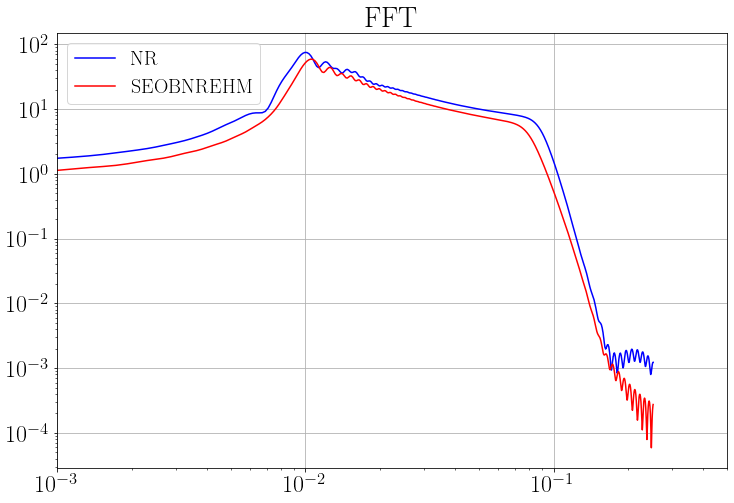

In [69]:
#---------------------------------------------------------------------------
#fourier and another plot
h_px=np.array([times,sxs_wave]).T 
h_eob=np.array([times,h_seobe_nr]).T 
tlow_nr = h_eob[0,0]+ 150
thigh_nr = 150
sigmalo = 100
tlow_eob = h_eob[0,0]+ 150
thigh_eob = 150
px_fft=FFT_ZeroPadded_Windowed( h_px, 
                                   nleft=1000,
                                   nright=1000,
                                   x_low=tlow_nr, 
                                   sigma_low=sigmalo,
                                   x_high=thigh_nr,
                                   sigma_high=sigmalo)
eob_fft=FFT_ZeroPadded_Windowed(h_eob,
                                    nleft=1000,
                                    nright=1000,
                                    x_low=tlow_eob,
                                    sigma_low=sigmalo,
                                    x_high=thigh_eob,
                                    sigma_high=sigmalo)
flow = 8
delta_f = 1.0 /16
flen = int(2048 / delta_f) + 1
frange=np.arange(flow,flow+delta_f*flen,delta_f)
psd_noise = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_int=interp1d(frange, psd_noise, kind='cubic')

plt.figure(figsize = (12, 8))
plt.plot(px_fft[:,0], np.abs(px_fft[:,1]),'b',label='NR')
plt.plot(eob_fft[:,0], np.abs(eob_fft[:,1]),'r',label=model)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlim(0.001,0.5)
plt.title("FFT")

In [ ]:
def EasyMatch(h1,h2,psd_int,fMin,fMax,nright=300,f_units='Hz',mass=1):
    '''
    Compute the mismatch between two waveforms
    '''
    if f_units=='Mf':
        scale=202994.5445851929/mass;
        f=scale*h1[:,0]
    elif f_units=='Hz':
        f=h1[:,0]

    h1red=h1[:,1]
    h2red=h2[:,1]

    boolean=np.logical_and(f >= fMin,f <= fMax)
    fnew=f[boolean]
    h1red=h1red[boolean]
    h2red=h2red[boolean]
    psddat=psd_int(fnew)

    tableS=1/psddat;
    norm1=np.sum(np.abs(h1red)**2 *tableS);
    norm2=np.sum(np.abs(h2red)**2 *tableS);

    myTable=h1red*np.conj(h2red)* tableS;
    df=fnew[1]-fnew[0];
    ts=np.column_stack((fnew,myTable))
    nleft=np.int(np.real(np.rint(df/fnew[0])))
    myTable=ZeroPadTimeSeries(ts,nleft,nright)[:,1]
    prod=len(myTable)*ifft(myTable);
    res=np.max(np.abs(prod)/np.sqrt(norm1*norm2))
    return res

In [51]:
#---------------------------------------------------------------------------
print("Mismatch: "+ str(1-EasyMatch(px_fft,eob_fft,psd_int,20,2000,nright=3000,f_units='Mf',mass=mass)))

#mismatch between different masses
mass = range(10,200)
mismatch = []
for m in mass:
    fmin=max(fun.f_to_Phys(f_0,m),20)
    #print(fmin)
    mm = 1-EasyMatch(px_fft,eob_fft,psd_int,fmin,1000,nright=3000,f_units='Mf',mass=m)
    mismatch.append(mm)

Mismatch: 0.030631708706985394


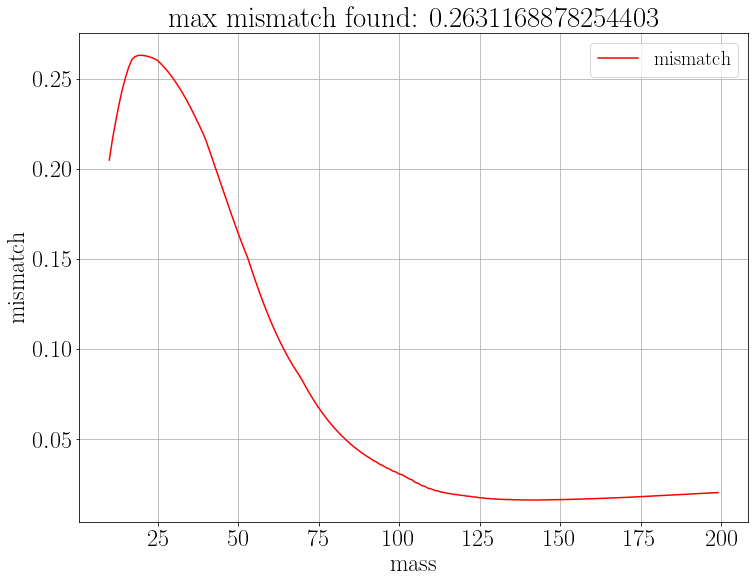

In [56]:
plt.figure(figsize = (12, 9))
plt.plot(mass, mismatch,'r',label=r'mismatch')
plt.legend()
plt.title("max mismatch found: " + str(np.max(mismatch)))
plt.xlabel('mass')
plt.ylabel('mismatch')
plt.show()